In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import StructType,IntegerType,FloatType,BooleanType
conf = SparkConf().setMaster("local[*]").setAppName("My App")
sc = SparkContext.getOrCreate(conf = conf)
spark=SparkSession.builder.appName('myApp').getOrCreate()

In [2]:
def load_data(files,schema):
    df=spark.read.csv(files,header=True
                  ,schema=schema)
    return df

def load_record_linkage_data():
    schema = StructType() \
      .add("id_1",IntegerType(),True) \
      .add("id_2",IntegerType(),True) \
      .add("cmp_fname_c1",FloatType(),True) \
      .add("cmp_fname_c2",FloatType(),True) \
      .add("cmp_lname_c1",FloatType(),True) \
      .add("cmp_lname_c2",FloatType(),True) \
      .add("cmp_sex",IntegerType(),True) \
      .add("cmp_bd",IntegerType(),True) \
      .add("cmp_bm",IntegerType(),True) \
      .add("cmp_by",IntegerType(),True) \
      .add("cmp_plz",IntegerType(),True) \
      .add("is_match",BooleanType(),False)
    files=[f'./data/block_{id}.csv' for id in range(1,11)]
    return load_data(files,schema=schema)

In [3]:
df=load_record_linkage_data()

In [4]:
df.groupBy('cmp_plz').count().show()

+-------+-------+
|cmp_plz|  count|
+-------+-------+
|   null|  12843|
|      1|  31714|
|      0|5704575|
+-------+-------+



In [5]:
df.count()

5749132

In [6]:
df.printSchema()

root
 |-- id_1: integer (nullable = true)
 |-- id_2: integer (nullable = true)
 |-- cmp_fname_c1: float (nullable = true)
 |-- cmp_fname_c2: float (nullable = true)
 |-- cmp_lname_c1: float (nullable = true)
 |-- cmp_lname_c2: float (nullable = true)
 |-- cmp_sex: integer (nullable = true)
 |-- cmp_bd: integer (nullable = true)
 |-- cmp_bm: integer (nullable = true)
 |-- cmp_by: integer (nullable = true)
 |-- cmp_plz: integer (nullable = true)
 |-- is_match: boolean (nullable = true)



# Missing Values

### Drop Missing Values


In [7]:
miss_df=df.drop('id_1','id_2')

اگر همه داده های گم شده را حذف کنیم، کلا 20 رکورد باقی می‌ ماند !


In [8]:
miss_df.replace('?',None).na.drop().count()

20

In [9]:
miss_df=miss_df.replace('?',None)

In [10]:
miss_df.head(3)

[Row(cmp_fname_c1=0.8333333134651184, cmp_fname_c2=None, cmp_lname_c1=1.0, cmp_lname_c2=None, cmp_sex=1, cmp_bd=1, cmp_bm=1, cmp_by=1, cmp_plz=0, is_match=True),
 Row(cmp_fname_c1=1.0, cmp_fname_c2=None, cmp_lname_c1=1.0, cmp_lname_c2=None, cmp_sex=1, cmp_bd=1, cmp_bm=1, cmp_by=1, cmp_plz=1, is_match=True),
 Row(cmp_fname_c1=1.0, cmp_fname_c2=None, cmp_lname_c1=1.0, cmp_lname_c2=None, cmp_sex=1, cmp_bd=1, cmp_bm=1, cmp_by=1, cmp_plz=1, is_match=True)]

هیچ رکوردی که همه یا حداقل 2 تا از متغیرهای آن گم شده باشد، وجود ندارد

In [11]:
miss_df.na.drop(how='all').count()

5749132

In [12]:
miss_df.na.drop(how='any',thresh=2).count()

5749132

### Fill the Missing Values

In [13]:
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import when, lit
# for float variables



def convert_label_binary(input_df):
    temp = input_df.withColumn('label',
                             when(input_df['is_match']==True,
                                  lit(1)).otherwise(0)
                                  ) 
    return temp

def fill_missing_values(input_df):
    miss_df=input_df.drop('id_1','id_2')
    miss_df=miss_df.replace('?',None)
    float_cols=[
    'cmp_fname_c1', 
    'cmp_fname_c2', 
    'cmp_lname_c1', 
    'cmp_lname_c2', 
    ]
    float_imputer = Imputer(
        inputCols=float_cols,
        outputCols=[f"{col}_imputed" for col in float_cols]
    ).setStrategy('mean')

    # for binary variables
    binary_cols=[
        'cmp_sex', 
        'cmp_bd', 
        'cmp_bm', 
        'cmp_by',
        'cmp_plz',
    ]
    binary_imputer = Imputer(
        inputCols=binary_cols,
        outputCols=[f"{col}_imputed" for col in binary_cols]
    ).setStrategy('mode')
    imputed_df=float_imputer.fit(miss_df).transform(miss_df)
    output_df=binary_imputer.fit(imputed_df).transform(imputed_df)
    output_df=output_df.select([x for x in output_df.columns if '_imputed' in x or x=='is_match'])
    return output_df


def preprocessing_df(input_df):
    return convert_label_binary(fill_missing_values(input_df))

In [14]:
prep_df=preprocessing_df(df)


In [15]:
prep_df.groupBy('cmp_fname_c1_imputed').count().show()

+--------------------+-------+
|cmp_fname_c1_imputed|  count|
+--------------------+-------+
|          0.27272728|    454|
|           0.8181818|      3|
|          0.16666667| 152732|
|                0.25| 137039|
|               0.875|  71211|
|           0.5714286|   7414|
|          0.47058824|     11|
|                0.75|  46521|
|                 0.1|  10357|
|          0.11111111| 123127|
|               0.125| 155172|
|          0.36363637|    293|
|           0.7777778|   3083|
|                 0.6|  19725|
|                 0.9|   7780|
|                 0.5|  44615|
|          0.42857143|  34463|
|           0.2857143|  78429|
|          0.33333334|  94936|
|                 1.0|3508203|
+--------------------+-------+
only showing top 20 rows



In [16]:
prep_df.show(1,truncate=False)

+--------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+--------------+--------------+---------------+-----+
|is_match|cmp_fname_c1_imputed|cmp_fname_c2_imputed|cmp_lname_c1_imputed|cmp_lname_c2_imputed|cmp_sex_imputed|cmp_bd_imputed|cmp_bm_imputed|cmp_by_imputed|cmp_plz_imputed|label|
+--------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+--------------+--------------+---------------+-----+
|true    |0.8333333           |0.9000177           |1.0                 |0.31841284          |1              |1             |1             |1             |0              |1    |
+--------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+--------------+--------------+---------------+-----+
only showing top 1 row



In [17]:
prep_df[prep_df['label']>0].show(3,truncate=False)

+--------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+--------------+--------------+---------------+-----+
|is_match|cmp_fname_c1_imputed|cmp_fname_c2_imputed|cmp_lname_c1_imputed|cmp_lname_c2_imputed|cmp_sex_imputed|cmp_bd_imputed|cmp_bm_imputed|cmp_by_imputed|cmp_plz_imputed|label|
+--------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+--------------+--------------+---------------+-----+
|true    |0.8333333           |0.9000177           |1.0                 |0.31841284          |1              |1             |1             |1             |0              |1    |
|true    |1.0                 |0.9000177           |1.0                 |0.31841284          |1              |1             |1             |1             |1              |1    |
|true    |1.0                 |0.9000177           |1.0                 |0.31841284          |1              |

In [18]:
from pyspark.ml.feature import FeatureHasher,OneHotEncoder,VectorAssembler,StringIndexer
def feature_engineering(input_df,feature_list,label_name):
    assembler = VectorAssembler(inputCols=feature_list,
                             outputCol='features')
    assembled_df = assembler.transform(input_df)
    output_df=assembled_df.select('features', label_name)
    return output_df

In [19]:
features=list(set(prep_df.columns) - set(['label','is_match']))

assembled_df = feature_engineering(prep_df,features,'label')
assembled_df.show(5, truncate=False)

+----------------------------------------------------------------------------------+-----+
|features                                                                          |label|
+----------------------------------------------------------------------------------+-----+
|[0.3184128403663635,1.0,1.0,0.8333333134651184,1.0,1.0,0.9000176787376404,1.0,0.0]|1    |
|[0.3184128403663635,1.0,1.0,1.0,1.0,1.0,0.9000176787376404,1.0,1.0]               |1    |
|[0.3184128403663635,1.0,1.0,1.0,1.0,1.0,0.9000176787376404,1.0,1.0]               |1    |
|[0.3184128403663635,1.0,1.0,1.0,1.0,1.0,0.9000176787376404,1.0,1.0]               |1    |
|[1.0,1.0,1.0,1.0,1.0,1.0,0.9000176787376404,1.0,1.0]                              |1    |
+----------------------------------------------------------------------------------+-----+
only showing top 5 rows



In [20]:
def test_train_split(input_df,train_size=0.7):
    train, test = assembled_df.randomSplit([train_size,1 - train_size], seed=42)
    return train,test

In [21]:
train, test = test_train_split(assembled_df,0.7)
train.count()

4025517

In [22]:
prep_df.groupBy('label').count().show()

+-----+-------+
|label|  count|
+-----+-------+
|    1|  20931|
|    0|5728201|
+-----+-------+



### ML Models

In [23]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier,LogisticRegression
from pyspark.ml import Pipeline

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
def evaluate_from_scratch(pred,model_name='Logistic Regression'):
    pred.groupBy('label', 'prediction').count().show()

    # Calculate the elements of the confusion matrix
    TN = pred.filter('prediction = 0 AND label = prediction').count()
    TP = pred.filter('prediction = 1 AND label = prediction').count()
    FN = pred.filter('prediction = 0 AND label = 1').count()
    FP = pred.filter('prediction = 1 AND label = 0').count()

    # Accuracy measures the proportion of correct predictions
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    recall = (TP) / (TP+FN)
    precision= (TP) / (TP+FP)
    f1=2*(precision*recall)/(precision+recall)
    print(f'EVALUATION SUMMARY for {model_name}:')
    print(f" precision:{precision}")
    print(f" recall:{recall}")
    print(f" f1-score:{f1}")

def evaluate_from_spark(predictions,model_name='Logistic Regression'):
    eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
    eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    AUC  = eval.evaluate(predictions)
    ACC  = eval2.evaluate(predictions, {eval2.metricName:"accuracy"})
    PREC  = eval2.evaluate(predictions, {eval2.metricName:"weightedPrecision"})
    REC  = eval2.evaluate(predictions, {eval2.metricName:"weightedRecall"})
    F1  = eval2.evaluate(predictions, {eval2.metricName:"f1"})
    WeightedFMeasure=eval2.evaluate(predictions, {eval2.metricName:"weightedFMeasure"})
    print(f"{model_name} Performance Measure")
    print(" Accuracy = %0.8f" % ACC)
    print(" Weighted Precision = %0.8f" % PREC)
    print(" Weighted Recall = %0.8f" % REC)
    print(" F1 = %0.8f" % F1)
    print(" Weighted F Measure = %0.8f" % WeightedFMeasure)

    print(" AUC = %.8f" % AUC)
    print(" ROC curve:")
    PredAndLabels           = predictions.select("probability", "label")
    PredAndLabels_collect   = PredAndLabels.collect()
    PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
    PredAndLabels           = sc.parallelize(PredAndLabels_list)
    fpr = dict()                                                        # FPR: False Positive Rate
    tpr = dict()                                                        # TPR: True Positive Rate
    roc_auc = dict()
    
    y_test = [i[1] for i in PredAndLabels_list]
    y_score = [i[0] for i in PredAndLabels_list]
    
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.8f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.yticks(np.arange(0,1.03,0.1))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    

def evaluate(predictions,model_name=None):
    print('Evaluate From Scratch:')
    evaluate_from_scratch(predictions,model_name)
    print('\nEvaluate From Spark Library:')
    evaluate_from_spark(predictions,model_name)

In [25]:
# lr=LogisticRegression(featuresCol='features', labelCol='label')
# lr_model = lr.fit(train)
# lr_result = lr_model.transform(test)

In [32]:
lr=LogisticRegression(featuresCol='features', labelCol='label')
pipeline = Pipeline(stages=[lr])
model = pipeline.fit(train)
lr_result = model.transform(test)

In [33]:
lr_result.select('label', 'prediction', 'probability').show(3)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.99999999999992...|
|    0|       0.0|[0.99999999999961...|
|    0|       0.0|[0.99999999999999...|
+-----+----------+--------------------+
only showing top 3 rows



Evaluate From Scratch:
+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    0|       0.0|1717390|
|    1|       1.0|   6205|
|    1|       0.0|     11|
|    0|       1.0|      9|
+-----+----------+-------+

EVALUATION SUMMARY for Logistic Regression:
accuracy:0.9999883964806526 
precision:0.9985516575474734 
recall:0.9982303732303732 
f1-score:0.998390989541432

Evaluate From Spark Library:
Logistic Regression Performance Measure
 Accuracy = 0.99998840
 Weighted Precision = 0.99998839
 Weighted Recall = 0.99998840
 F1 = 0.99998840
 AUC = 0.99999986
 ROC curve:


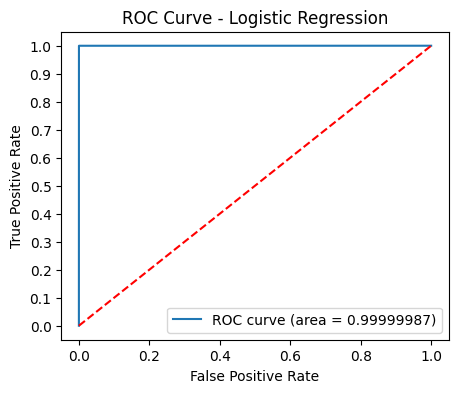

In [48]:
evaluate(lr_result)

### Decision Tree

In [49]:
tree = DecisionTreeClassifier()
tree_pipeline = Pipeline(stages=[tree])
tree_model = tree_pipeline.fit(train)
tree_result = tree_model.transform(test)

Evaluate From Scratch:
+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    1|       0.0|     36|
|    0|       0.0|1717390|
|    1|       1.0|   6180|
|    0|       1.0|      9|
+-----+----------+-------+

EVALUATION SUMMARY for Decision Tree:
 precision:0.9985458070770722
 recall:0.9942084942084942
 f1-score:0.9963724304715841

Evaluate From Spark Library:
Decision Tree Performance Measure
 Accuracy = 0.99997389
 Weighted Precision = 0.99997387
 Weighted Recall = 0.99997389
 F1 = 0.99997386
 AUC = 0.99944268
 ROC curve:


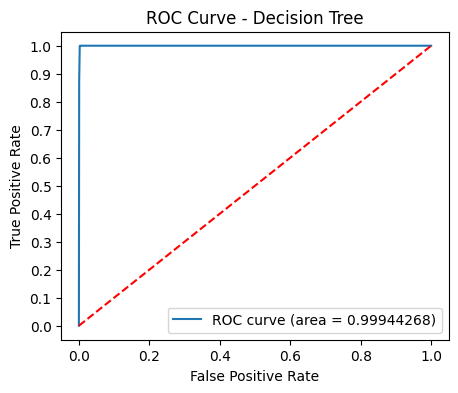

In [53]:
evaluate(tree_result,model_name='Decision Tree')

### RandomForest

In [55]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
rf_pipeline = Pipeline(stages=[ rf])
rf_model=rf_pipeline.fit(train)
rf_result=rf_model.transform(test)

Evaluate From Scratch:
+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    1|       0.0|     66|
|    0|       0.0|1717398|
|    1|       1.0|   6150|
|    0|       1.0|      1|
+-----+----------+-------+

EVALUATION SUMMARY for Random Forest:
 precision:0.9998374248089742
 recall:0.9893822393822393
 f1-score:0.9945823562707206

Evaluate From Spark Library:
Random Forest Performance Measure
 Accuracy = 0.99996113
 Weighted Precision = 0.99996112
 Weighted Recall = 0.99996113
 F1 = 0.99996103
 Weighted F Measure = 0.99996103
 AUC = 0.99999974
 ROC curve:


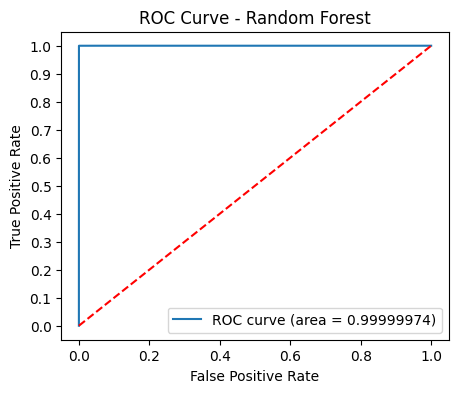

In [56]:
evaluate(rf_result,model_name='Random Forest')

# Not Refactored yet...


### Cross Validation 

In [57]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [58]:
lr_cs = LogisticRegression()

In [59]:
from pyspark.ml.classification import LogisticRegression
lr_cs = LogisticRegression()
grid = ParamGridBuilder().addGrid(lr_cs.regParam, [0.1, 0.01]) \
    .addGrid(lr_cs.fitIntercept, [False, True])\
    .addGrid(lr_cs.elasticNetParam, [0.0, 1.0])\
    .build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr_cs, estimatorParamMaps=grid, evaluator=evaluator)
cvModel = cv.fit(train)
lrprediction=cvModel.transform(test)



print('Accuracy:', evaluator.evaluate(lrprediction))
print('AUC:', BinaryClassificationMetrics(lrprediction['label','prediction'].rdd).areaUnderROC)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "c:\wamp64\www\spark_project\venv\lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "C:\Users\Mohammadreza\AppData\Local\Programs\Python\Python38\lib\socket.py", line 669, in readinto
    return self._sock.recv_into(b)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\wamp64\www\spark_project\venv\lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "c:\wamp64\www\spark_project\venv\lib\site-packages\py4j\clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Tracebac

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [ ]:
evaluate(lrprediction)

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier()
grid = ParamGridBuilder() \
        .addGrid(dt.maxDepth,  [2, 5, 10, 20, 30]) \
        .addGrid(dt.maxBins,  [10, 20, 40, 80, 100]) \
        .build()
dtevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
cv = CrossValidator(estimator=dt, 
                    estimatorParamMaps=grid, 
                    evaluator=dtevaluator,
                    numFolds = 3)
dtModel = cv.fit(train)
dtpredictions = dtModel.transform(test)

print('Accuracy:', dtevaluator.evaluate(dtpredictions))
print('AUC:', BinaryClassificationMetrics(dtpredictions['label','prediction'].rdd).areaUnderROC)

In [ ]:
evaluate(dtpredictions)